# Prepaid Package Analysis

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
    * [3.1. Understanding Data](#review)
	* [3.2. Data Cleaning](#clean)
	* [3.3. Improve Data Quality](#imp)
	* [3.4. Understanding Terms and Conditions for Each Plan](#plan)
	* [3.5. Aggregating Data](#agg)
* [4. Exploratory Analysis](#eda)
	* [4.1. Calls](#cal)
	* [4.2. Messages](#mess)
	* [4.3. Internet](#int)
	* [4.4. Income from Each Plan](#inc)
* [5. Hypothesis Testing](#ht)
* [6. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

Telecommunications operator Megaline offers its customers two prepaid packages, Surf and Ultimate. The advertising department wants to know which prepaid package generates more revenue in order to adjust the advertising budget.

As an analyst, you will conduct an initial analysis for these prepaid packages based on a relatively small sample of Megaline customers. You will have 500 data points of Megaline customers: who they are, where they are from, what package they use, as well as the number of calls and messages they sent in 2018. Your task is to analyze customer behavior and determine which prepaid package brings in more revenue.

**Prepaid Package Description**<br>
Note: Megaline rounds seconds to minutes and megabits to gigabits. For calls, each individual call is rounded up: even if the call lasts only one second, it will be counted as one minute. For web traffic, each web session is not rounded up. However, the total for the month is rounded up. If a user consumes 1025 megabits this month, they will be charged for 2 gigabits.

**Surf:**
1. Monthly cost: \$20
2. 500 minutes of call duration per month, 50 SMS, and 15 GB data
3. After exceeding the package limits, the following charges apply:
 * 1 minute: 3 cents
 * 1 SMS: 3 cents
 * 1 GB data: $10

**Ultimate:**
1. Monthly cost: \$70
2. 3000 minutes of call duration per month, 1000 SMS, and 30 GB data
3. After exceeding the package limits, the following charges apply:
 * 1 minute: 1 cent
 * 1 SMS: 1 cent
 * 1 GB data: $7

### 1.2. Objectives

The research aims to answer the following two questions:
* Is the average revenue from Surf prepaid package users greater than that of Ultimate package users?
* Is the average revenue from users in the NY-NJ region different from the revenue of users from other regions?

### 1.3. Data Description

Files used in this research are:
* megaline_calls.csv
    * id — unique session ID
    * call_date — call date
    * duration — call duration (in minutes)
    * user_id — user ID who made the call
* megaline_internet.csv
    * id — unique session ID
    * mb_used — data volume consumed during the session (in megabits)
    * session_date — web session date
    * user_id — user ID
* megaline_messages.csv
    * id — unique SMS ID
    * message_date — message date
    * user_id — user ID who sent the message
* megaline_plans.csv
    * plan_name — telephone plan name
    * usd_monthly_fee — monthly fee in US dollars
    * minutes_included — monthly allocated call minutes
    * messages_included — monthly allocated SMS
    * mb_per_month_included — monthly allocated data volume (in megabits)
    * usd_per_minute — price per minute if exceeding the package allocation (e.g., if the plan has an allocation of 100 minutes, usage starting from the 101st minute will incur a cost)
    * usd_per_message — price per SMS if exceeding the package allocation
    * usd_per_gb — price per extra gigabit of data if exceeding the package allocation (1 GB = 1024 megabits)
* megaline_users.csv
    * user_id — user ID
    * first_name — user's first name
    * last_name — user's last name
    * age — user's age (in years)
    * reg_date — subscription start date (dd, mm, yy)
    * churn_date — date when the user stopped using the service (if the value is missing or non-existent, it means the service package was in use when this data was created)
    * city — user's city of residence
    * plan — telephone plan name

N.B. Megaline rounds seconds to minutes and megabits to gigabits. For calls, each individual call is rounded up: even if a call lasts only one second, it will be counted as one minute. For web traffic, each individual web session is not rounded up. However, the total for the month is rounded up. If a user consumes 1025 megabits this month, they will be charged for 2 gigabits.

### 1.4. Methodology

This research follows the following steps:
1. Initial data exploration
2. Data transformation to improve data quality
3. Enriching the data with additional variables
4. Data manipulation by merging relevant data
5. Studying user behavior and revenue per package
6. Hypothesis testing
7. Drawing conclusions.

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

### 2.1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

### 2.2. Import Data

In [2]:
calls = pd.read_csv('datasets/megaline_calls.csv')
internet = pd.read_csv('datasets/megaline_internet.csv')
messages = pd.read_csv('datasets/megaline_messages.csv')
plans = pd.read_csv('datasets/megaline_plans.csv')
users = pd.read_csv('datasets/megaline_users.csv')

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

In [3]:
files = [calls, internet, messages, users, plans]
table_names = ["Calls", "Internet", "Messages", "Users", "Plans"]

#Define function for understanding data
def basic_explore(data):
    print("---------First 5 Rows of The Dataframe---------")
    display(data.head(5))
    print("-----------Data shape =", data.shape, "-----------")
    print()
    print("------------------Basic Info------------------")
    display(data.info())
    print("--------------Statistics Summary--------------")
    display(data.describe())
    print("----------------------------------------------")

### 3.1. Understanding Data <a id='review'></a>

#### 3.1.1. Calls

Here are some basic information regarding calls dataset:

In [4]:
basic_explore(files[0])

---------First 5 Rows of The Dataframe---------


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


-----------Data shape = (137735, 4) -----------

------------------Basic Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


None

--------------Statistics Summary--------------


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


----------------------------------------------


This dataset has **137735** rows and **4** columns.<br>
There is no missing values.<br>
`call_date` column is not in datetime datatype.

#### 3.1.2. Internet

Here are some basic information regarding internet dataset:

In [5]:
basic_explore(files[1])

---------First 5 Rows of The Dataframe---------


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


-----------Data shape = (104825, 4) -----------

------------------Basic Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


None

--------------Statistics Summary--------------


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


----------------------------------------------


This dataset has **104825** rows and **4** columns.<br>
There is no missing values.<br>
`session_date` column is not in datetime datatype.

#### 3.1.3. Messages

Here are some basic information regarding messages dataset:

In [6]:
basic_explore(files[2])

---------First 5 Rows of The Dataframe---------


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


-----------Data shape = (76051, 3) -----------

------------------Basic Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


None

--------------Statistics Summary--------------


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


----------------------------------------------


This dataset has **76051** rows and **3** columns.<br>
There is no missing values.<br>
`message_date` column is not in datetime datatype.

#### 3.1.4. Users

Here are some basic information regarding users dataset:

In [7]:
basic_explore(files[3])

---------First 5 Rows of The Dataframe---------


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


-----------Data shape = (500, 8) -----------

------------------Basic Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

--------------Statistics Summary--------------


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


----------------------------------------------


This dataset has **500** rows and **8** columns.<br>
There are some missing values in `churn_date`. These missing values indicate that the package is still in use when this database is made.<br>
`reg_date, churn_date` column is not in datetime datatype.

#### 3.1.5. Plans

Here are some basic information regarding plans dataset:

In [8]:
basic_explore(files[4])

---------First 5 Rows of The Dataframe---------


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


-----------Data shape = (2, 8) -----------

------------------Basic Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


None

--------------Statistics Summary--------------


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


----------------------------------------------


This dataset has **2** rows and **8** columns.<br>
There is no missing values.<br>
All columns are in the right datatypes.

[back to table of contents](#back)

### 3.2. Data Cleaning <a id='clean'></a>

Data is missing only on the `churn date`, and this missing data indicates that the service package was being used when this data was created.
The data contains date values in all tables, but they are still in object format instead of datetime format, so they need to be changed:
1. calls - call_date
2. internet - session_date
3. messages - message_date
4. users - reg_date, churn_date

In [9]:
users["churn_date"].fillna(0, inplace = True)

In [10]:
def to_datetime(data, column):
    data[column] = pd.to_datetime(data[column], format="%Y-%m-%d")
    
columns = [["call_date"], ["session_date"], ["message_date"], ["reg_date", "churn_date"]]

for i in range(len(columns)):
    for j in range(len(columns[i])):
        to_datetime(files[i], columns[i][j])

[back to table of contents](#back)

### 3.3. Improve Data Quality <a id='imp'></a>

In general, each data which has single column will be improve by adding month column.

In [11]:
def derived_month(data, column):
    data[f"{column}_month"] = data[column].dt.month.astype('int16')

In [12]:
for i in range(len(columns)):
    for j in range(len(columns[i])):
        derived_month(files[i], columns[i][j])

Users data will be improved by adding **'NY-NJ'** indicator with 1 value for user who lives in that area.

In [13]:
users['NY-NJ'] = users['city'].str.contains('NY-NJ')
users['NY-NJ'] = users['NY-NJ'].astype(int)

[back to table of contents](#back)

### 3.4. Understanding Terms and Conditions for Each Plan <a id='plan'></a>

In [14]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [15]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [16]:
plans.describe()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


These are the terms and conditions for each plan:

**Surf:**
* Monthly cost: \$20
* 500 minutes of call duration per month, 50 SMS, and 15 GB data
* After exceeding the package limits, the following charges apply:
  * 1 minute: 3 cents
  * 1 SMS: 3 cents
  * 1 GB data: $10

**Ultimate:**
* Monthly cost: \$70
* 3000 minutes of call duration per month, 1000 SMS, and 30 GB data
* After exceeding the package limits, the following charges apply:
  * 1 minute: 1 cent
  * 1 SMS: 1 cent
  * 1 GB data: $7

Note that data quota is in **GB** which is different from usage data in `users` table which is in **MB**.

### 3.5. Aggregating Data <a id='agg'></a>

Now we will combine `calls, messages, dan internet` per user grouped by usage month.

In [17]:
# Calculate calls made by each user per month
calls_group = calls.groupby(["user_id","call_date_month"])["duration"].agg(['count','sum'])
calls_group.index.names = ["user_id","month"]

In [18]:
# Calculate messages made by each user per month
messages_group = messages.groupby(["user_id","message_date_month"])['message_date'].count()
messages_group.index.names = ["user_id","month"]

In [19]:
# Calculate data usage by each user per month
internet_group = internet.groupby(["user_id","session_date_month"]).sum()
internet_group.index.names = ["user_id","month"]

Combine data usage per unique user per specific month.

In [20]:
usage = calls_group.join(messages_group).join(internet_group)

Combine data usage with plans.

In [21]:
usage_and_plan = usage.join(users[['user_id','plan','NY-NJ']].set_index('user_id')).reset_index()

In [22]:
usage_and_plan = usage_and_plan.rename(columns = {
    "count" : "num_of_calls",
    "sum" : "total_duration_in_mins",
    "message_date" : "num_of_messages",
    "mb_used" : "total_mb_used",
    "plan" : "plan"
})

In [23]:
usage_and_plan.fillna(0, inplace=True)

In [24]:
# Calculate income from each user
df = usage_and_plan.merge(plans, left_on=("plan"), right_on=("plan_name"))

In [25]:
df

,user_id,month,num_of_calls,total_duration_in_mins,num_of_messages,total_mb_used,plan,NY-NJ,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16,116.83,11.0,1901.47,ultimate,0,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1006,11,2,9.32,15.0,2068.37,ultimate,0,1000,30720,3000,70,7,0.01,0.01,ultimate
2,1006,12,9,54.79,139.0,32118.82,ultimate,0,1000,30720,3000,70,7,0.01,0.01,ultimate
3,1008,10,71,450.21,21.0,17106.99,ultimate,0,1000,30720,3000,70,7,0.01,0.01,ultimate
4,1008,11,63,422.81,37.0,23676.72,ultimate,0,1000,30720,3000,70,7,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,1498,12,39,324.77,0.0,23137.69,surf,1,50,15360,500,20,10,0.03,0.03,surf
2254,1499,9,41,330.37,0.0,12984.76,surf,0,50,15360,500,20,10,0.03,0.03,surf
2255,1499,10,53,363.28,0.0,19492.43,surf,0,50,15360,500,20,10,0.03,0.03,surf
2256,1499,11,45,288.56,0.0,16813.83,surf,0,50,15360,500,20,10,0.03,0.03,surf


To calculate the monthly revenue from each user, the steps followed are:
* Subtract the free package limit from the total number of calls, text messages, and data used by the user.
* Multiply the result by the call package rate.
* Add the monthly fee based on the type of call package.

In [26]:
df['extra_messages'] = df.apply(lambda x: (x['num_of_messages'] - x['messages_included'])
                                if x['num_of_messages'] > x['messages_included'] else 0, axis = 1)
df['extra_minutes'] = df.apply(lambda x: (x['total_duration_in_mins'] - x['minutes_included'])
                                if x['total_duration_in_mins'] > x['minutes_included'] else 0, axis = 1)
df['extra_mb_used'] = df.apply(lambda x: (x['total_mb_used'] - x['mb_per_month_included'])
                                if x['total_mb_used'] > x['mb_per_month_included'] else 0, axis = 1)

df['income_from_extra_messages'] = df['extra_messages'] * df['usd_per_message']
df['income_from_extra_minutes'] = df.apply(lambda x: 
        (np.ceil(x['extra_minutes'] if x['extra_minutes'] > 0 else 0) * x['usd_per_gb']),axis=1)
df['income_from_extra_mb_used'] = df.apply(lambda x: 
        ((np.ceil(x['extra_mb_used']/1024) if x['extra_mb_used'] > 0 else 0) * x['usd_per_gb']),axis=1)

df['extra_income'] = df['income_from_extra_messages'] + df['income_from_extra_minutes'] + df['income_from_extra_mb_used']

df['total_income'] = df['usd_monthly_pay'] + df['extra_income']

In [27]:
df.sample(5)

,user_id,month,num_of_calls,total_duration_in_mins,num_of_messages,total_mb_used,plan,NY-NJ,messages_included,mb_per_month_included,...,usd_per_minute,plan_name,extra_messages,extra_minutes,extra_mb_used,income_from_extra_messages,income_from_extra_minutes,income_from_extra_mb_used,extra_income,total_income
2037,1408,8,63,363.51,49.0,17535.93,surf,0,50,15360,...,0.03,surf,0.0,0.00,2175.93,0.0,0.0,30.0,30.0,50.0
72,1043,9,28,188.60,101.0,32619.76,ultimate,1,1000,30720,...,0.01,ultimate,0.0,0.00,1899.76,0.0,0.0,14.0,14.0,84.0
482,1370,12,93,671.37,30.0,14854.91,ultimate,0,1000,30720,...,0.01,ultimate,0.0,0.00,0.00,0.0,0.0,0.0,0.0,70.0
825,1046,12,83,604.53,32.0,13891.55,surf,0,50,15360,...,0.03,surf,0.0,104.53,0.00,0.0,1050.0,0.0,1050.0,1070.0
399,1273,10,39,224.56,44.0,10722.53,ultimate,0,1000,30720,...,0.01,ultimate,0.0,0.00,0.00,0.0,0.0,0.0,0.0,70.0


[back to table of contents](#back)

## 4. Exploratory Analysis <a id='eda'></a>

Here we will create several graphs for each type of usage per package.

To compare prepaid packages and determine which prepaid package is more beneficial, statistical calculations and graphs should be performed for each package.

### 4.1. Calls <a id='cal'></a>

In [28]:
df_calls_surf = df[df['plan'] == 'surf'].groupby('month').agg({"user_id" : "count", "total_duration_in_mins" : "sum"}).reset_index()
df_calls_ulti = df[df['plan'] == 'ultimate'].groupby('month').agg({"user_id" : "count", "total_duration_in_mins" : "sum"}).reset_index()

In [29]:
df_calls_surf["avg_duration"] = df_calls_surf["total_duration_in_mins"] / df_calls_surf["user_id"]
df_calls_ulti["avg_duration"] = df_calls_ulti["total_duration_in_mins"] / df_calls_ulti["user_id"]

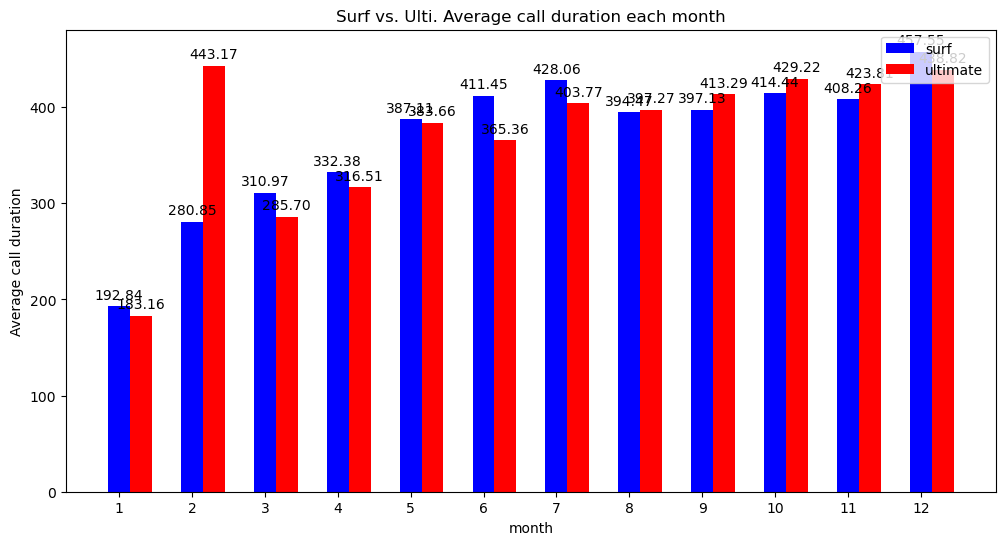

In [30]:
ind = np.arange(1,13)

plt.figure(figsize=(12,6))

df_calls_surf_bars = plt.bar(ind, df_calls_surf['avg_duration'], width = 0.3, color = 'blue', label = 'surf')
df_calls_ulti_bars = plt.bar(ind + 0.3, df_calls_ulti['avg_duration'], width = 0.3, color = 'red', label = 'ultimate')

plt.title("Surf vs. Ulti. Average call duration each month")
plt.xlabel("month")
plt.ylabel("Average call duration")
plt.xticks(ind)
plt.legend(loc=1)

for bar in df_calls_surf_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
for bar in df_calls_ulti_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
    
plt.show()

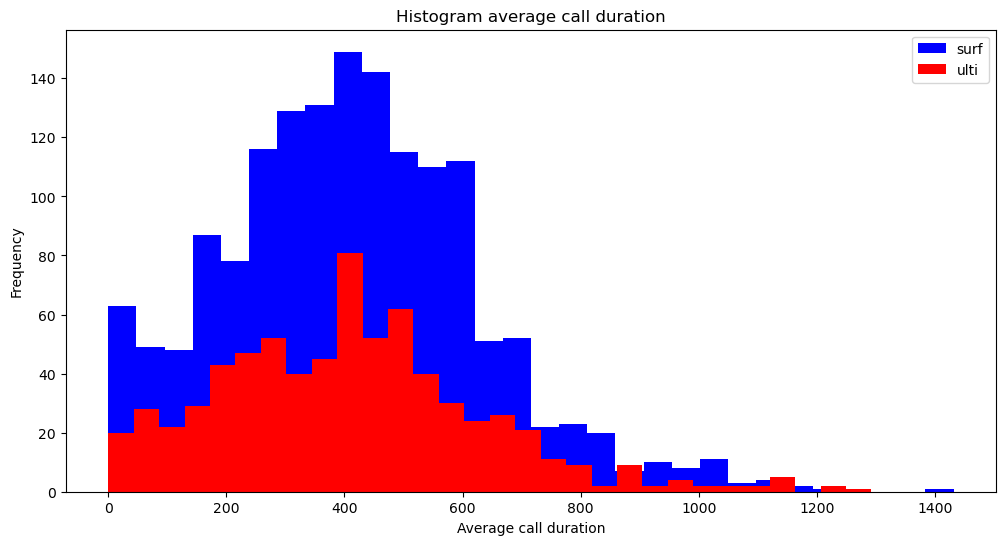

In [31]:
# Compare calls minutes for each user per month.
plt.figure(figsize=(12,6))
plt.hist(df[df['plan'] == 'surf']['total_duration_in_mins'], bins = 30, color = 'blue', label = 'surf')
plt.hist(df[df['plan'] == 'ultimate']['total_duration_in_mins'], bins = 30, color = 'red', label = 'ulti')
plt.title("Histogram average call duration")
plt.xlabel("Average call duration")
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()

In [32]:
# Calculate mean and variance of monthly calls duration
surf_call_mean = np.mean(df[df['plan'] == 'surf']['total_duration_in_mins'])
surf_call_var = np.var(df[df['plan'] == 'surf']['total_duration_in_mins'])
ulti_call_mean = np.mean(df[df['plan'] == 'ultimate']['total_duration_in_mins'])
utli_call_var = np.var(df[df['plan'] == 'ultimate']['total_duration_in_mins'])
print("Surf package mean =", surf_call_mean, "and variance =", surf_call_var)
print("Ultimate package mean =", ulti_call_mean, "and variance =", utli_call_var)

Surf package mean = 412.09788996763723 and variance = 46970.83270700408
Ultimate package mean = 410.1809537166893 and variance = 50439.789304279846


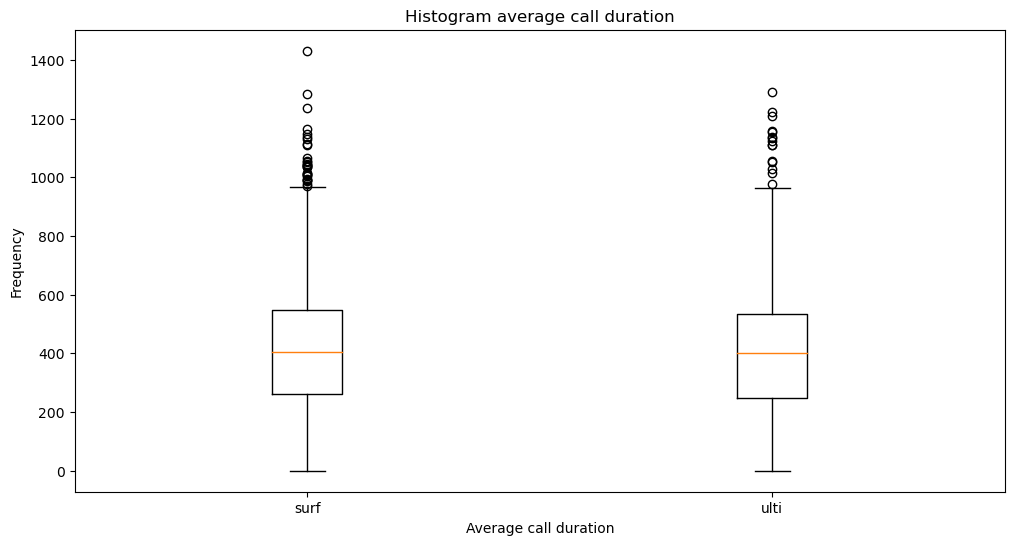

In [33]:
# Visualize monthly calls duration distribution
plt.figure(figsize=(12,6))
plt.boxplot([df[df['plan']=='surf']['total_duration_in_mins'],df[df['plan']=='ultimate']['total_duration_in_mins']], labels = ['surf','ulti'])
plt.title("Histogram average call duration")
plt.xlabel("Average call duration")
plt.ylabel("Frequency")
plt.show()

The call duration is not significantly different between the two packages. The call duration for both packages appears to generally increase from January to December, except for the ultimate package in February.

### 4.2. Messages <a id='mess'></a>

In [34]:
df_mess_surf = df[df['plan'] == 'surf'].groupby('month').agg({"user_id" : "count", "num_of_messages" : "sum"}).reset_index()
df_mess_ulti = df[df['plan'] == 'ultimate'].groupby('month').agg({"user_id" : "count", "num_of_messages" : "sum"}).reset_index()

In [35]:
df_mess_surf["avg_messages_per_id"] = df_mess_surf["num_of_messages"] / df_mess_surf["user_id"]
df_mess_ulti["avg_messages_per_id"] = df_mess_ulti["num_of_messages"] / df_mess_ulti["user_id"]

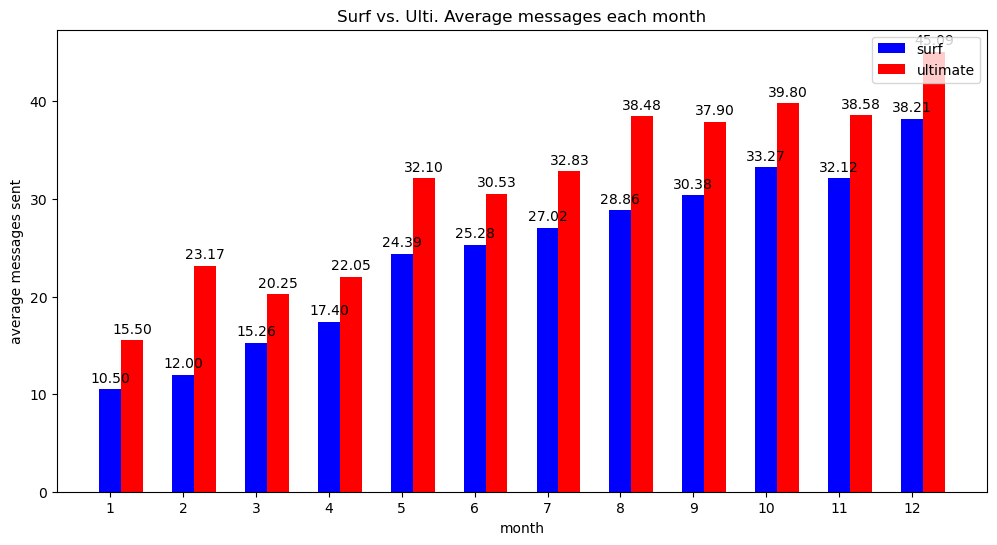

In [36]:
ind = np.arange(1,13)

plt.figure(figsize=(12,6))

df_mess_surf_bars = plt.bar(ind, df_mess_surf['avg_messages_per_id'], width = 0.3, color = 'blue', label = 'surf')
df_mess_ulti_bars = plt.bar(ind + 0.3, df_mess_ulti['avg_messages_per_id'], width = 0.3, color = 'red', label = 'ultimate')

plt.title("Surf vs. Ulti. Average messages each month")
plt.xlabel("month")
plt.ylabel("average messages sent")
plt.xticks(ind)
plt.legend(loc=1)

for bar in df_mess_surf_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
for bar in df_mess_ulti_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')

plt.show()

In [37]:
surf_mess_mean = np.mean(df[df['plan'] == 'surf']['num_of_messages'])
surf_mess_var = np.var(df[df['plan'] == 'surf']['num_of_messages'])
ulti_mess_mean = np.mean(df[df['plan'] == 'ultimate']['num_of_messages'])
utli_mess_var = np.var(df[df['plan'] == 'ultimate']['num_of_messages'])
print("Surf package mean =", surf_mess_mean, "and variance =", surf_mess_var)
print("Ultimate package mean =", ulti_mess_mean, "and variance =", utli_mess_var)

Surf package mean = 30.897734627831714 and variance = 1131.216726259677
Ultimate package mean = 37.725105189340816 and variance = 1208.4461719735089


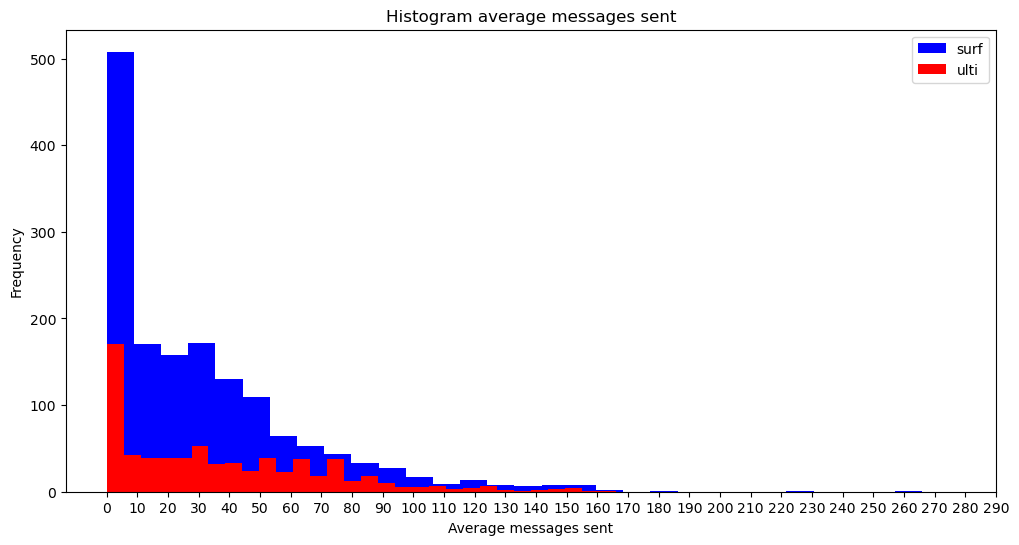

In [38]:
plt.figure(figsize=(12,6))
plt.hist(df[df['plan']=='surf']['num_of_messages'], bins=30, color = 'blue', label = 'surf')
plt.hist(df[df['plan']=='ultimate']['num_of_messages'], bins=30, color = 'red', label = 'ulti')
plt.title("Histogram average messages sent")
plt.xlabel("Average messages sent")
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.xticks(np.arange(0,300,10))
plt.show()

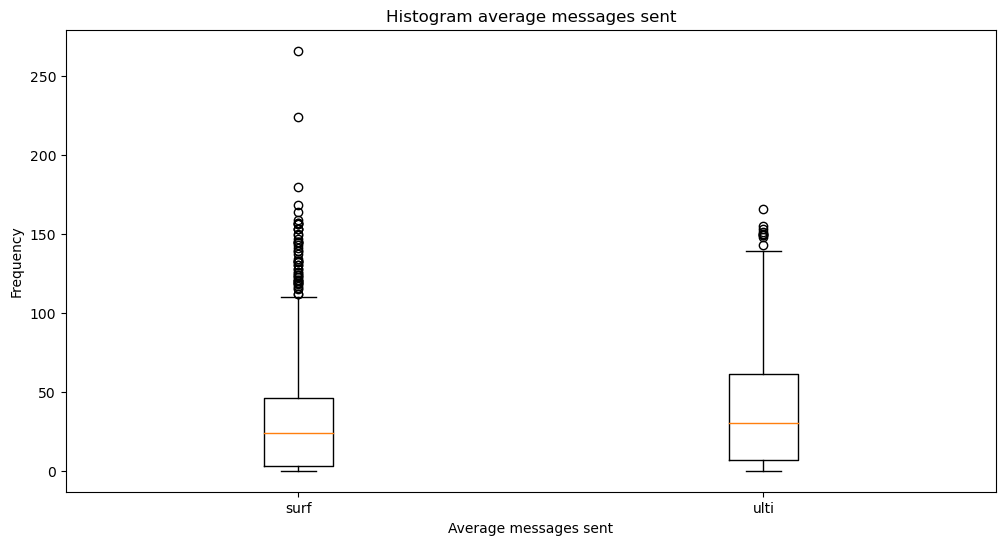

In [39]:
plt.figure(figsize=(12,6))
plt.boxplot([df[df['plan']=='surf']['num_of_messages'],df[df['plan']=='ultimate']['num_of_messages']], labels = ['surf','ulti'])
plt.title("Histogram average messages sent")
plt.xlabel("Average messages sent")
plt.ylabel("Frequency")
plt.show()

The number of messages/SMS sent is not significantly different between the two packages. The number of messages/SMS sent for both packages appears to generally increase from January to December.

### 4.3. Internet <a id='int'></a>

In [40]:
df_int_surf = df[df['plan'] == 'surf'].groupby('month').agg({"user_id" : "count", "total_mb_used" : "sum"}).reset_index()
df_int_ulti = df[df['plan'] == 'ultimate'].groupby('month').agg({"user_id" : "count", "total_mb_used" : "sum"}).reset_index()

In [41]:
df_int_surf["avg_mb_used_per_id"] = df_int_surf["total_mb_used"] / df_int_surf["user_id"]
df_int_ulti["avg_mb_used_per_id"] = df_int_ulti["total_mb_used"] / df_int_ulti["user_id"]

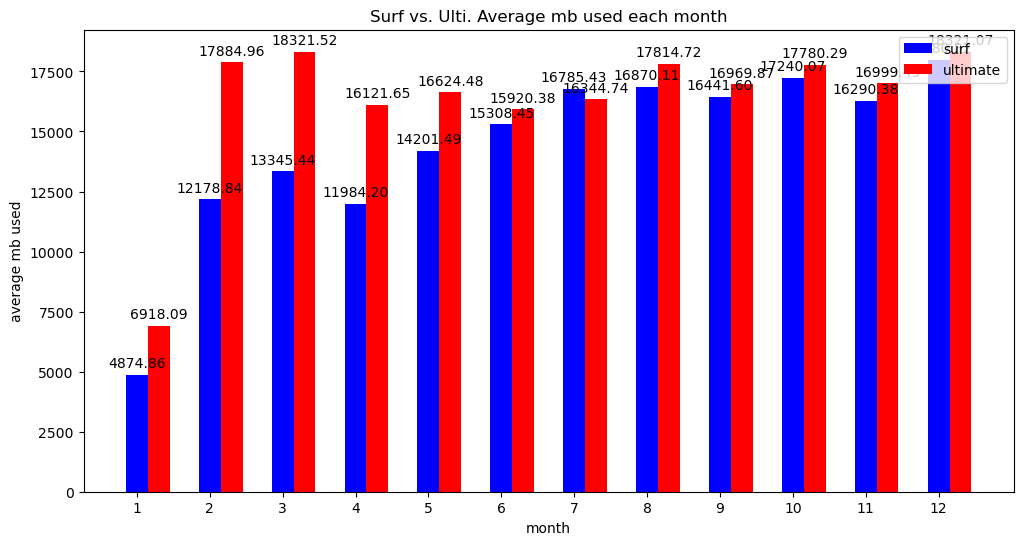

In [42]:
ind = np.arange(1,13)

plt.figure(figsize=(12,6))

df_int_surf_bars = plt.bar(ind, df_int_surf['avg_mb_used_per_id'], width = 0.3, color = 'blue', label = 'surf')
df_int_ulti_bars = plt.bar(ind + 0.3, df_int_ulti['avg_mb_used_per_id'], width = 0.3, color = 'red', label = 'ultimate')

plt.title("Surf vs. Ulti. Average mb used each month")
plt.xlabel("month")
plt.ylabel("average mb used")
plt.xticks(ind)
plt.legend(loc=1)

for bar in df_int_surf_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
for bar in df_int_ulti_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
    
plt.show()

In [43]:
surf_int_mean = np.mean(df[df['plan'] == 'surf']['total_mb_used'])
surf_int_var = np.var(df[df['plan'] == 'surf']['total_mb_used'])
ulti_int_mean = np.mean(df[df['plan'] == 'ultimate']['total_mb_used'])
utli_int_var = np.var(df[df['plan'] == 'ultimate']['total_mb_used'])
print("Surf package mean =", surf_int_mean, "and variance =", surf_int_var)
print("Ultimate package mean=", ulti_int_mean, "and variance =", utli_int_var)

Surf package mean = 16505.727372168283 and variance = 61548356.835211955
Ultimate package mean= 17278.003730715296 and variance = 60127799.148781724


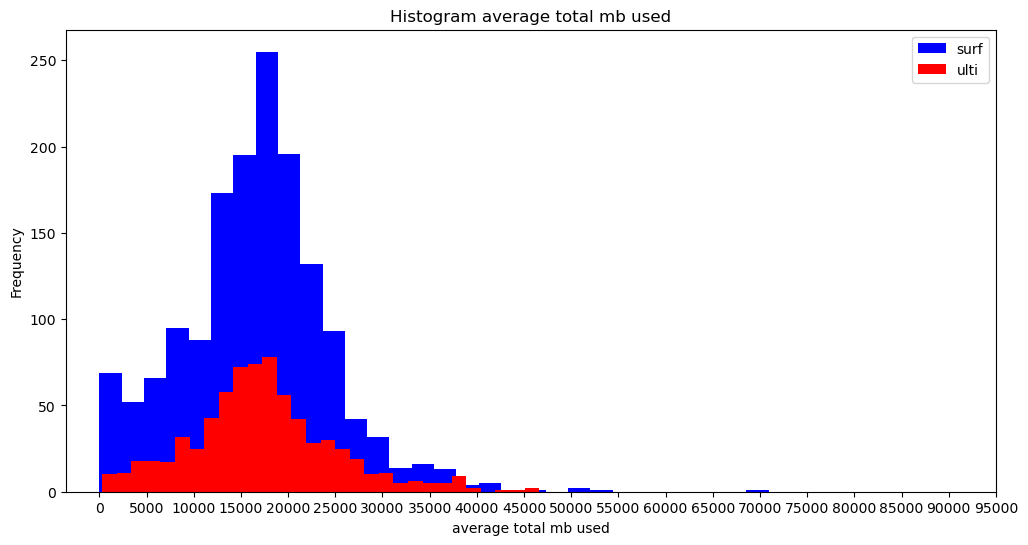

In [44]:
plt.figure(figsize=(12,6))
plt.hist(df[df['plan']=='surf']['total_mb_used'], bins=30, color = 'blue', label = 'surf')
plt.hist(df[df['plan']=='ultimate']['total_mb_used'], bins=30, color = 'red', label = 'ulti')
plt.title("Histogram average total mb used")
plt.xlabel("average total mb used")
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.xticks(np.arange(0,100000,5000))
plt.show()

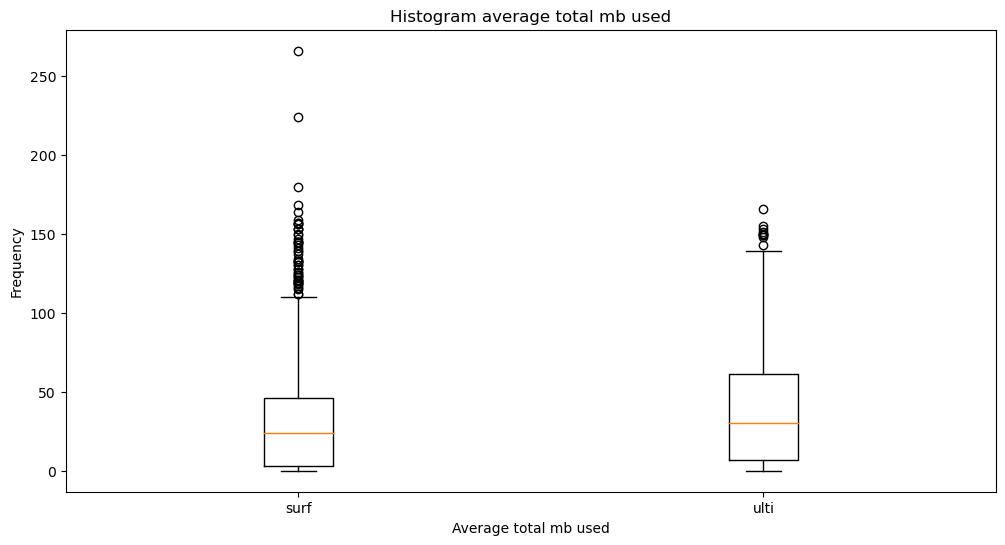

In [45]:
plt.figure(figsize=(12,6))
plt.boxplot([df[df['plan']=='surf']['num_of_messages'],df[df['plan']=='ultimate']['num_of_messages']], labels = ['surf','ulti'])
plt.title("Histogram average total mb used")
plt.xlabel("Average total mb used")
plt.ylabel("Frequency")
plt.show()

The monthly internet usage is not significantly different between the two packages. The internet usage for the surf package appears to generally increase from January to May. Meanwhile, for the ultimate package, it tends to remain stable per month, except for January.

### 4.4. Income from Each Plan <a id='inc'></a>

In [46]:
df_income_surf = df[df['plan'] == 'surf'].groupby('month').agg({"user_id" : "count", "total_income" : "sum"}).reset_index()
df_income_ulti = df[df['plan'] == 'ultimate'].groupby('month').agg({"user_id" : "count", "total_income" : "sum"}).reset_index()

In [47]:
df_income_surf["avg_total_income"] = df_income_surf["total_income"] / df_income_surf["user_id"]
df_income_ulti["avg_total_income"] = df_income_ulti["total_income"] / df_income_ulti["user_id"]

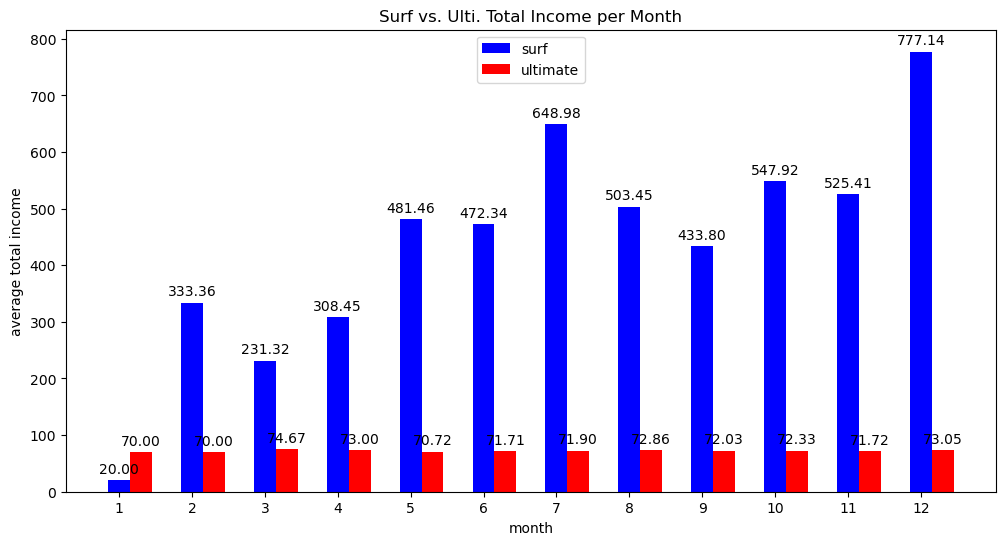

In [48]:
ind = np.arange(1,13)

plt.figure(figsize=(12,6))

df_inc_surf_bars = plt.bar(ind, df_income_surf['avg_total_income'], width = 0.3, color = 'blue', label = 'surf')
df_inc_ulti_bars = plt.bar(ind + 0.3, df_income_ulti['avg_total_income'], width = 0.3, color = 'red', label = 'ultimate')

plt.title("Surf vs. Ulti. Total Income per Month")
plt.xlabel("month")
plt.ylabel("average total income")
plt.xticks(ind)
plt.legend(loc=9)

for bar in df_inc_surf_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
for bar in df_inc_ulti_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom')
    
plt.show()

In [49]:
surf_inc_mean = np.mean(df[df['plan'] == 'surf']['total_income'])
surf_inc_var = np.var(df[df['plan'] == 'surf']['total_income'])
ulti_inc_mean = np.mean(df[df['plan'] == 'ultimate']['total_income'])
utli_inc_var = np.var(df[df['plan'] == 'ultimate']['total_income'])
print("Surf package mean =", surf_inc_mean, "and variance =", surf_inc_var)
print("Ultimate package mean =", ulti_inc_mean, "and variance =", utli_inc_var)

Surf package mean = 556.8696893203883 and variance = 1258045.381230318
Ultimate package mean = 72.27769985974754 and variance = 128.68585613992772


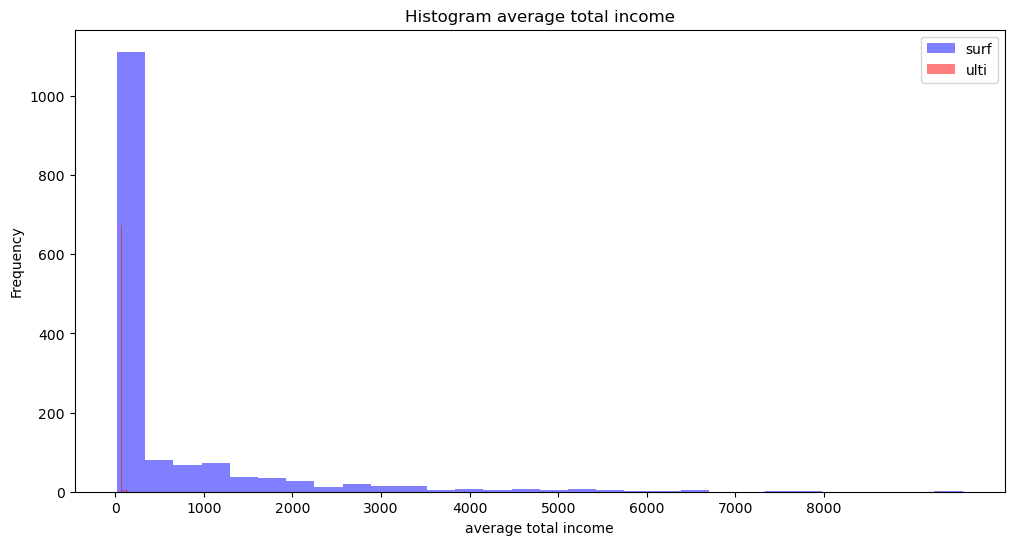

In [50]:
plt.figure(figsize=(12,6))
plt.hist(df[df['plan']=='surf']['total_income'], bins=30, color = 'blue', alpha = 0.5, label = 'surf')
plt.hist(df[df['plan']=='ultimate']['total_income'], bins=30, color = 'red', alpha = 0.5, label = 'ulti')
plt.title("Histogram average total income")
plt.xlabel("average total income")
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.xticks(np.arange(0,9000,1000))
plt.show()

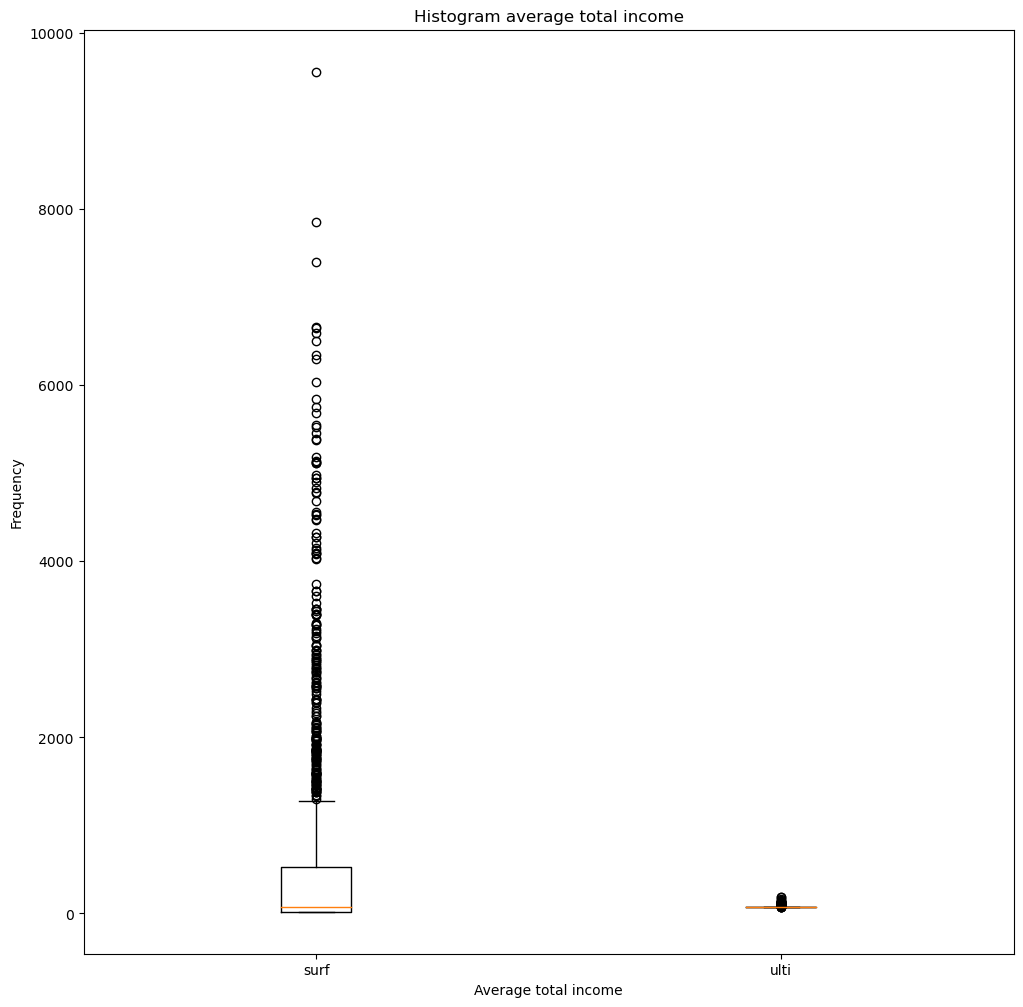

In [51]:
plt.figure(figsize=(12,12))
plt.boxplot([df[df['plan']=='surf']['total_income'],df[df['plan']=='ultimate']['total_income']], labels = ['surf','ulti'])
plt.title("Histogram average total income")
plt.xlabel("Average total income")
plt.ylabel("Frequency")
plt.show()

The average monthly revenue from the surf package is consistently higher than the ultimate package, except in January. In the histogram/boxplot, it is noticeable that the average revenue for the surf package has many outliers that pull the average revenue upwards. As a result, when calculating the average, the surf package's average revenue significantly exceeds the average revenue of the ultimate package.

[back to table of contents](#back)

## 5. Hypothesis Testing <a id='ht'></a>

Now we will test the hypothesis that states whether the average revenue from prepaid Surf package is greater than Ultimate package with a significance level (alpha) of 5%.

H0: The average income of Surf is smaller than Ultimate.<br>
H1: The average income of Surf is greater than Ultimate.

In [52]:
# test hypothesis
alpha = 0.05

results = st.ttest_ind(df[df['plan'] == 'surf']['total_income'], df[df['plan'] == 'ultimate']['total_income'])

print("p-value:", results.pvalue/2)

if results.pvalue/2 < alpha and surf_inc_mean > ulti_inc_mean:
    print("Reject H0. The average income of Surf is greater than Ultimate.")
else:
    print("Cannot reject H0. The average income of Surf is smaller than Ultimate.")

p-value: 3.118129345895975e-30
Reject H0. The average income of Surf is greater than Ultimate.


Now we will test the hypothesis that states whether the average income of users in the NY-NJ region is different from the income of users from other regions with a significance level (alpha) of 5%.

H0: The average income of users in the NY-NJ region is not different from the income of users from other regions.<br>
H1: The average income of users in the NY-NJ region is different from the income of users from other regions.

In [53]:
# test hypothesis
results = st.ttest_ind(df[df['NY-NJ'] == 0]['total_income'], df[df['NY-NJ'] == 1]['total_income'])

print("p-value:", results.pvalue)

if results.pvalue < alpha:
    print("Reject H0. The average income of users in the NY-NJ region is different from the income of users from other regions.")
else:
    print("Cannot reject H0. The average income of users in the NY-NJ region is not different from the income of users from other regions.")
    

p-value: 0.8944658442174298
Cannot reject H0. The average income of users in the NY-NJ region is not different from the income of users from other regions.


[back to table of contents](#back)

## 6. General Conclusion <a id='end'></a>

Data is only missing in the churn_date column of the user table. This missing data indicates that the service package was in use when this data was generated. Therefore, the missing churn_date data will be filled with a value of 0, having the same data type as the other data in that column. The data contains date values in the following tables and columns, which will be converted to datetime data type for further analysis:
1. Calls table - call_date column
2. Internet table - session_date column
3. Messages table - message_date column
4. Users table - reg_date and churn_date columns

Each data with a date column is then enriched by adding a month column, and the user data is enriched by adding an indicator '**NY-NJ**' with a value of 1 if the user resides in that area, to be used for further analysis.

These data are then combined and further analyzed using bar charts, histograms, and box plots. Based on the analysis, the call duration, the number of sent messages, and internet usage are not significantly different between the two packages. The usage data for both packages shows a general increasing trend from January to December.

To address the research objectives, hypothesis tests are conducted to answer two questions:
* Is the average revenue from the prepaid Surf package greater than the Ultimate package?
* Is the average revenue of users in the NY-NJ region different from the revenue of users in other regions?

A one-tailed t-test is conducted to answer the first question since it compares two distributions in one direction. For the second question, a two-tailed test is conducted. These tests are performed assuming that the compared data follow a normal distribution.

Based on the t-test hypothesis with a significance level of 5%, it can be concluded that the average income of Surf is greater than Ultimate, and the average income of users in the NY-NJ region is not different from the income of users from other regions.

[back to table of contents](#back)